In [87]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import glob
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler


# Data Processing

In [238]:
#Define the shape of the images and the batch size
image_size = (50, 50)
input_shape = (None,) + image_size + (3,)
batch_size = 32

In [239]:
#Set the paths for the train and validation directories
train_dir = pathlib.Path('Data/train')
val_dir = pathlib.Path('Data/valid')

In [240]:
#Create train and validation datasets
train_ds = image_dataset_from_directory(
    train_dir, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed = 42,
)

val_ds = image_dataset_from_directory(
    val_dir, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed = 42,
)

Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.


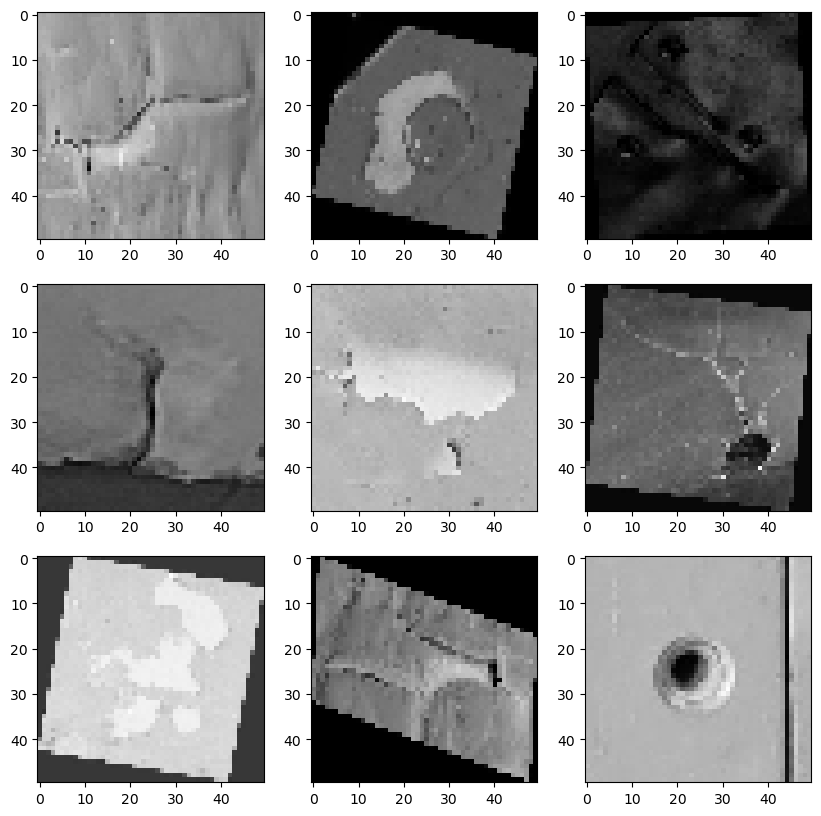

In [241]:
#Visualizing images from dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
       # plt.axis("off")

In [242]:
#Performance tuning the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [243]:
#Define rescale layer to be used as part of the model

rescale = tf.keras.Sequential([
    keras.layers.Rescaling(1./255),
])

In [244]:
#Data agmentation layers for the training set only

data_augmentation = keras.models.Sequential([
    keras.layers.RandomZoom(0.3), 
    keras.layers.RandomRotation(0.3)
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [245]:
#Create an L2 regularizer

l2_reg = keras.regularizers.l2(0.1)

In [246]:
#Building the model

model = keras.models.Sequential([
    rescale,
    layers.Conv2D(64, 3, strides=1, padding='same', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 2, strides=1, padding='same', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 2, padding='same', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 2, padding='same', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 2, padding='same', kernel_regularizer=l2_reg),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, 'softmax')
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 50, 50, 3)         0         
                                                                 
 conv2d_125 (Conv2D)         (None, 50, 50, 64)        1792      
                                                                 
 batch_normalization_125 (Ba  (None, 50, 50, 64)       256       
 tchNormalization)                                               
                                                                 
 re_lu_125 (ReLU)            (None, 50, 50, 64)        0         
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 25, 25, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_126 (Conv2D)         (None, 25, 25, 128)     

In [247]:
#Initializing the optimizer

opt = keras.optimizers.Adam()

In [252]:
#Define a lr schedule

def lr_schedule(epoch, lr):
    if epoch < 5:
        return 0.001
    else:
        return 0.00007
    
lr_scheduler = LearningRateScheduler(lr_schedule)

In [249]:
#Complile the model

model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
)

In [253]:
#Define checkpoint and early stopping callbacks

checkpoint_cb = keras.callbacks.ModelCheckpoint("current_model.h5")

early_stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint_cb, early_stop_cb, lr_scheduler]


In [254]:
#Fitting and training the model

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    callbacks=callbacks
)

Epoch 1/100
61/61 [==============================] - 6s 92ms/step - loss: 23.8061 - accuracy: 0.4578 - val_loss: 11.6798 - val_accuracy: 0.2019 - lr: 0.0010
Epoch 2/100
61/61 [==============================] - 6s 99ms/step - loss: 6.9339 - accuracy: 0.5484 - val_loss: 4.4154 - val_accuracy: 0.2019 - lr: 0.0010
Epoch 3/100
61/61 [==============================] - 6s 95ms/step - loss: 3.0779 - accuracy: 0.5633 - val_loss: 2.6813 - val_accuracy: 0.2019 - lr: 0.0010
Epoch 4/100
61/61 [==============================] - 6s 99ms/step - loss: 1.9300 - accuracy: 0.5870 - val_loss: 2.1390 - val_accuracy: 0.2019 - lr: 0.0010
Epoch 5/100
61/61 [==============================] - 6s 95ms/step - loss: 1.5969 - accuracy: 0.5644 - val_loss: 1.9706 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 6/100
61/61 [==============================] - 6s 99ms/step - loss: 1.5086 - accuracy: 0.6174 - val_loss: 1.7175 - val_accuracy: 0.5336 - lr: 7.0000e-05
Epoch 7/100
61/61 [==============================] - 6s 98ms/ste

In [255]:
#Final model results

val_loss, val_acc = model.evaluate(val_ds)

14/14 [==============================] - 0s 27ms/step - loss: 0.7976 - accuracy: 0.7912


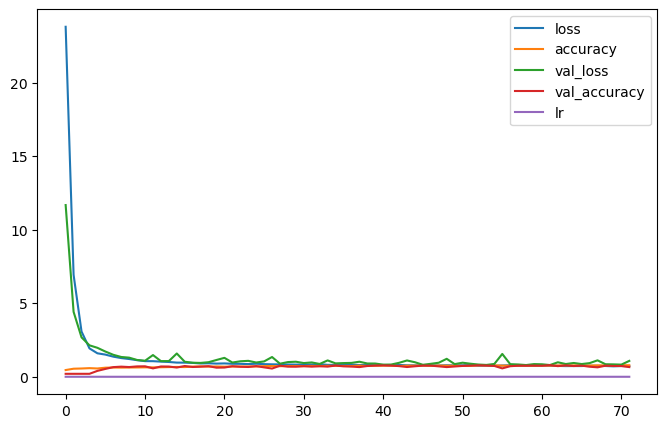

In [256]:
#Plotting training history

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [182]:
#Save model

model.save("shape_50_loss_0.6965.keras")